In [3]:
import numpy as np
import pandas as pd
import dask.dataframe as dk
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# file_path = "Processed_Data/Mapped_Dataset.csv"
# file_path="C:/Users/hoang/FileCSV_DACN_2025/Benign_ddos_dos_Mapped_Dataset.csv"
file_path = "single_file.csv"

df = dk.read_csv(file_path)

In [2]:
"""
Kiểm tra dataset sau khi xử lý
"""
df = dk.read_csv("single_file.csv")
    
# Tính tổng số mẫu
total_samples = df.shape[0].compute()
print(f"Tổng số mẫu: {total_samples}")
    
# Tính phân bố label
label_counts = df['label'].value_counts().compute()
print("Phân bố label:")
print(label_counts.sort_index())
    
# Kiểm tra số lượng label liên tiếp (chỉ kiểm tra 1 triệu mẫu đầu để tiết kiệm tài nguyên)
df_small = df.head(5000000).compute()
labels = df_small['label'].values
max_consecutive = current = 1  

for i in range(1, len(labels)):
    if labels[i] == labels[i-1]:
        current += 1
        max_consecutive = max(max_consecutive, current)
    else:
        current = 1  # Reset bộ đếm khi label thay đổi

print(f"Chuỗi liên tiếp dài nhất trong 1 triệu mẫu đầu: {max_consecutive}")

Tổng số mẫu: 5098191
Phân bố label:
label
0    1098195
1    3999996
Name: count, dtype: int64


/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/dask/dataframe/core.py:8153: UserWarning: Insufficient elements for `head`. 5000000 elements requested, only 221783 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


AttributeError: 'DataFrame' object has no attribute 'compute'

label
0    1099278
1    3999435
Name: count, dtype: int64


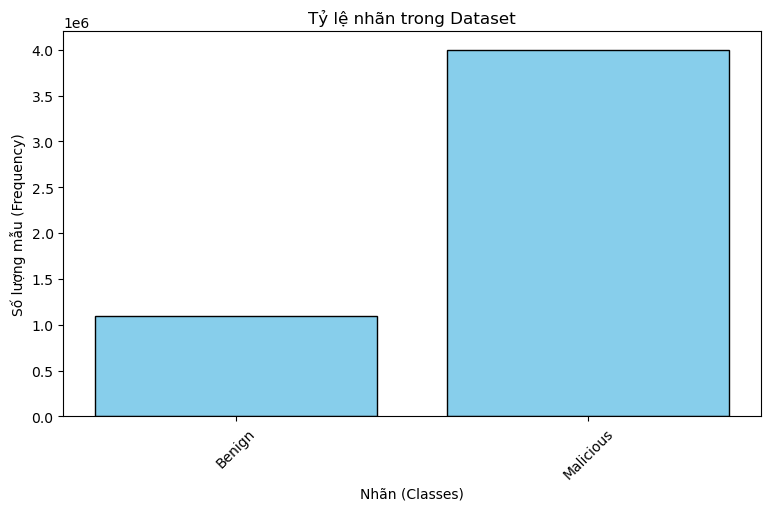

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/dask/dataframe/core.py:8153: UserWarning: Insufficient elements for `head`. 5000000 elements requested, only 222382 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(
/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/dask/dataframe/core.py:8153: UserWarning: Insufficient elements for `head`. 5000000 elements requested, only 222382 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


In [2]:
import matplotlib.pyplot as plt

# labels = ['BenignTraffic', 'DDoS-ICMP_Flood', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 
#                    'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood']
# Đếm số lượng mỗi nhãn
label_counts = df['label'].value_counts().compute()
print(label_counts)
labels = ["Benign", "Malicious"]
# Vẽ biểu đồ cột
plt.figure(figsize=(9, 5))
plt.bar(labels, label_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("Nhãn (Classes)")
plt.ylabel("Số lượng mẫu (Frequency)")
plt.title("Tỷ lệ nhãn trong Dataset")
plt.xticks(range(len(labels)) ,labels, rotation =45)
plt.show()

In [4]:
#Global var 
batch_size = 512
ratio_test_all = 0.20

from dask_ml.model_selection import train_test_split 
# chia train test ratio 0.8:0.2 & random 
train_df, val_test_df = train_test_split(df, test_size=ratio_test_all, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.75, random_state=42)

# # load từng batch
def dask_to_tf_dataset(dask_df, batch_size): 
    def generator():
        for batch in dask_df.to_delayed():
            batch = batch.compute()  
            if batch.empty:
                continue

            X = batch.drop(columns='label').values.astype(np.float32)
            y = batch['label'].values.astype(np.int32)  # nhị phân: 0 hoặc 1

            num_splits = max(1, len(X) // batch_size)
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y, num_splits)

            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch

    output_signature = ( 
        tf.TensorSpec(shape=(None, 46), dtype=tf.float32), 
        tf.TensorSpec(shape=(None,), dtype=tf.int32),  # không phải one-hot nữa
    )
    
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/dask_ml/model_selection/_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(
/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/dask_ml/model_selection/_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


In [5]:
train_gen = dask_to_tf_dataset(train_df, 512).repeat()
test_gen = dask_to_tf_dataset(test_df, 512)
val_gen = dask_to_tf_dataset(val_df, 512).repeat()

I0000 00:00:1748090515.692309  193536 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
import math
n_samples =  np.ceil(train_df.shape[0])
steps_per_epoch = int(n_samples / (batch_size))
validation_steps = int(steps_per_epoch / (16))
print("Steps/Epoch: ", steps_per_epoch)
num_samples_test = test_df.shape[0].compute()
# Tính số batch
num_batches_test = int(np.ceil(num_samples_test / batch_size))
print("Batch test: ", num_batches_test)

Steps/Epoch:  7967
Batch test:  1494


In [10]:
from datetime import datetime, timedelta
import sys, os
# shape
features, labels = next(iter(train_gen))
input_shape = (features.shape[1], 1)
# output_shape = labels.shape[1]

print(f"Input Shape: {input_shape}")

from tensorflow import keras
# Định nghĩa mô hình CNN
# VGG, ...
# Conv2D, tabular, ...
# HE, tính tương thích của HE với CNN
# Tính chất data in, out; Học tăng cường
start_time = datetime.now()

model = keras.Sequential([
    #layers.Input(shape=input_shape),
    #layers.BatchNormalization(),
    #layers.Conv1D(filters=128, kernel_size=7, padding="same", activation="relu"),
    #layers.BatchNormalization(),
    #layers.MaxPooling1D(pool_size=2),
    #layers.Dropout(0.5),
    #layers.Flatten(),
    #layers.Dense(128, activation='relu'),
    layers.Input(shape=input_shape),
    #layers.Conv1D(filters=128, kernel_size=3, padding="same", strides=1, activation="relu"),
    layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    #layers.MaxPooling1D(pool_size=2),
    #layers.Conv1D(filters=128, kernel_size=3, padding="same", strides=1, activation="relu"),
    layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    #layers.Dense(64, activation='relu'),  
    #layers.Dropout(0.3),                  
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
# for batch in dataloader:
#     X_batch = batch[:, :-1]
#     y_batch = batch[:, -1]
#     y_onehot = to_categorical(y_batch, num_classes=10)
    
#     model.train_on_batch(X_batch, y_onehot, verbose=1)
from tensorflow.keras.callbacks import CSVLogger
os.makedirs("log_mono", exist_ok=True)
log_name = "log_mono/"+ datetime.now().strftime("%Hh%Mp__%d-%m-%Y")+".csv"
csv_logger = CSVLogger(log_name , append=True)
model.fit(train_gen, epochs=15, validation_data=val_gen, validation_steps= validation_steps , steps_per_epoch= steps_per_epoch, verbose = 1, callbacks=[csv_logger])


end_time = datetime.now()
simulated_time = end_time - start_time
model_name = "saved_model/cnn_model_2-0_batch512_" + datetime.now().strftime("%Hh%Mp__%d-%m-%Y")+".keras"
# Lưu mô hình
model.save(model_name)

print(f"Simulated time: {simulated_time}")

Input Shape: (46, 1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 46, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 46, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 46, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 46, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2944)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       376,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 427,905 (1.63 MB)

 Trainable params: 427,393 (1.63 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/15
7967/7967 ━━━━━━━━━━━━━━━━━━━━ 64s 8ms/step - accuracy: 0.9962 - loss: 0.0183 - val_accuracy: 0.9999 - val_loss: 2.2209e-04
Epoch 2/15
7967/7967 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.9998 - loss: 5.9834e-04 - val_accuracy: 1.0000 - val_loss: 1.6522e-04
Epoch 3/15
7967/7967 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.9999 - loss: 3.4304e-04 - val_accuracy: 0.9999 - val_loss: 1.5976e-04
Epoch 4/15
7967/7967 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.9999 - loss: 3.1988e-04 - val_accuracy: 1.0000 - val_loss: 1.2814e-04
Epoch 5/15
7967/7967 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.9999 - loss: 2.9412e-04 - val_accuracy: 0.9999 - val_loss: 2.0968e-04
Epoch 6/15
7967/7967 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.9999 - loss: 3.3850e-04 - val_accuracy: 1.0000 - val_loss: 1.3784e-04
Epoch 7/15
7967/7967 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - accuracy: 0.9999 - loss: 2.7855e-04 - val_accuracy: 1.0000 - val_loss: 1.0267e-04
Epoch 8/15
7967/7967 ━━━━━━━━━━

In [ ]:
from tensorflow.keras.models import load_model
#input_model = "saved_model/cnn_model_2-0_batch512_" + datetime.now().strftime("%Hh%Mp__%d-%m-%Y")+".keras"
model = load_model(model_name)

output = model.evaluate(test_gen, steps = num_batches_test)
print(f'Loss: {output[0]} Acc: {output[1]}')

2025-05-24 20:08:02.385377: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Precision:  0.999998332140814
Recall:  0.999953302045704
F1-Score:  0.9999758165863194


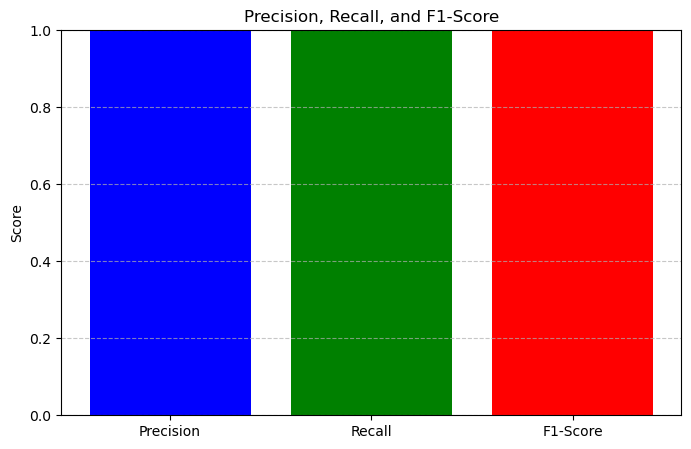

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

model = load_model(model_name)
#model = load_model("saved_model/cnn_model_2-0_batch512_20h37p__06-05-2025.keras")
# Tính số hàng thật sự trong test_df


y_true_all = []
y_pred_all = []

for X_batch, y_batch in test_gen.take(num_batches_test):
    y_true_all.extend(y_batch.numpy().flatten())

    y_pred_prob = model.predict(X_batch, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_pred_all.extend(y_pred)

# Tính metric
precision = precision_score(y_true_all, y_pred_all, average='binary')
recall = recall_score(y_true_all, y_pred_all, average='binary')
f1 = f1_score(y_true_all, y_pred_all, average='binary')

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1)

param_names = ['Precision', 'Recall', 'F1-Score']
array = [precision, recall, f1]

x = np.arange(len(param_names))
width = 0.2  # Độ rộng của mỗi cột
plt.figure(figsize=(8, 5))
plt.bar(param_names, array, color=['blue', 'green', 'red'])

# Cấu hình trục và nhãn
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score")
plt.ylim(0, 1)  # Giá trị từ 0 đến 1
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()


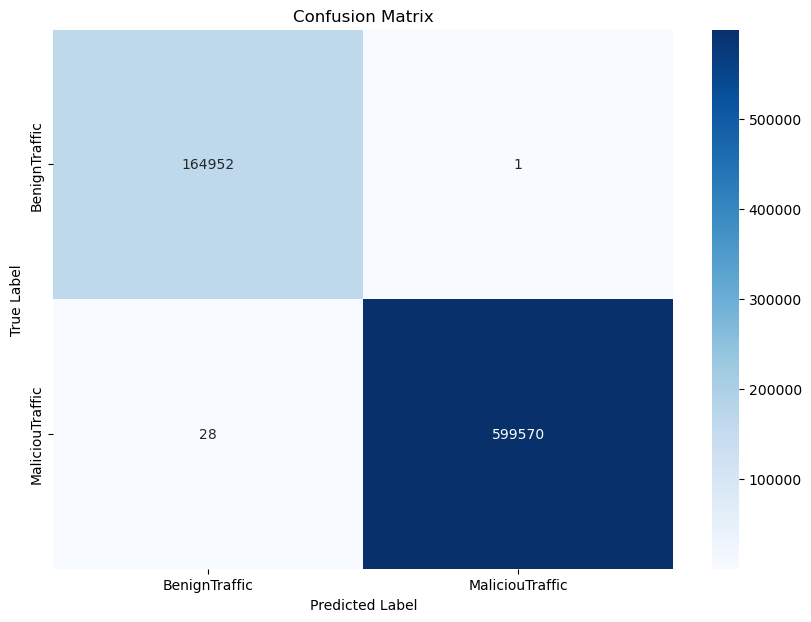

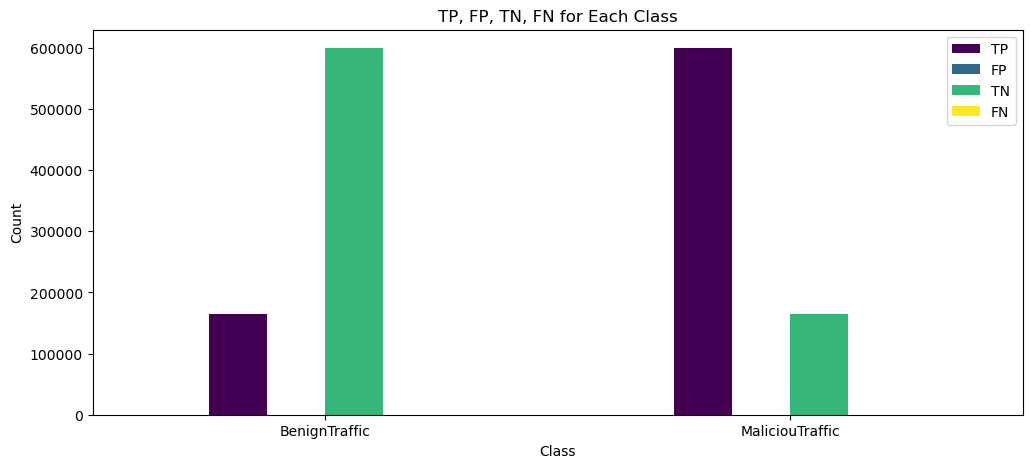

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_true_all, y_pred_all)

attack_types =['BenignTraffic', 'MaliciouTraffic']
# Vẽ heatmap
plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)

# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Hiển thị
plt.show()


metrics = []
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])
# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class")
plt.xticks(rotation=0)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

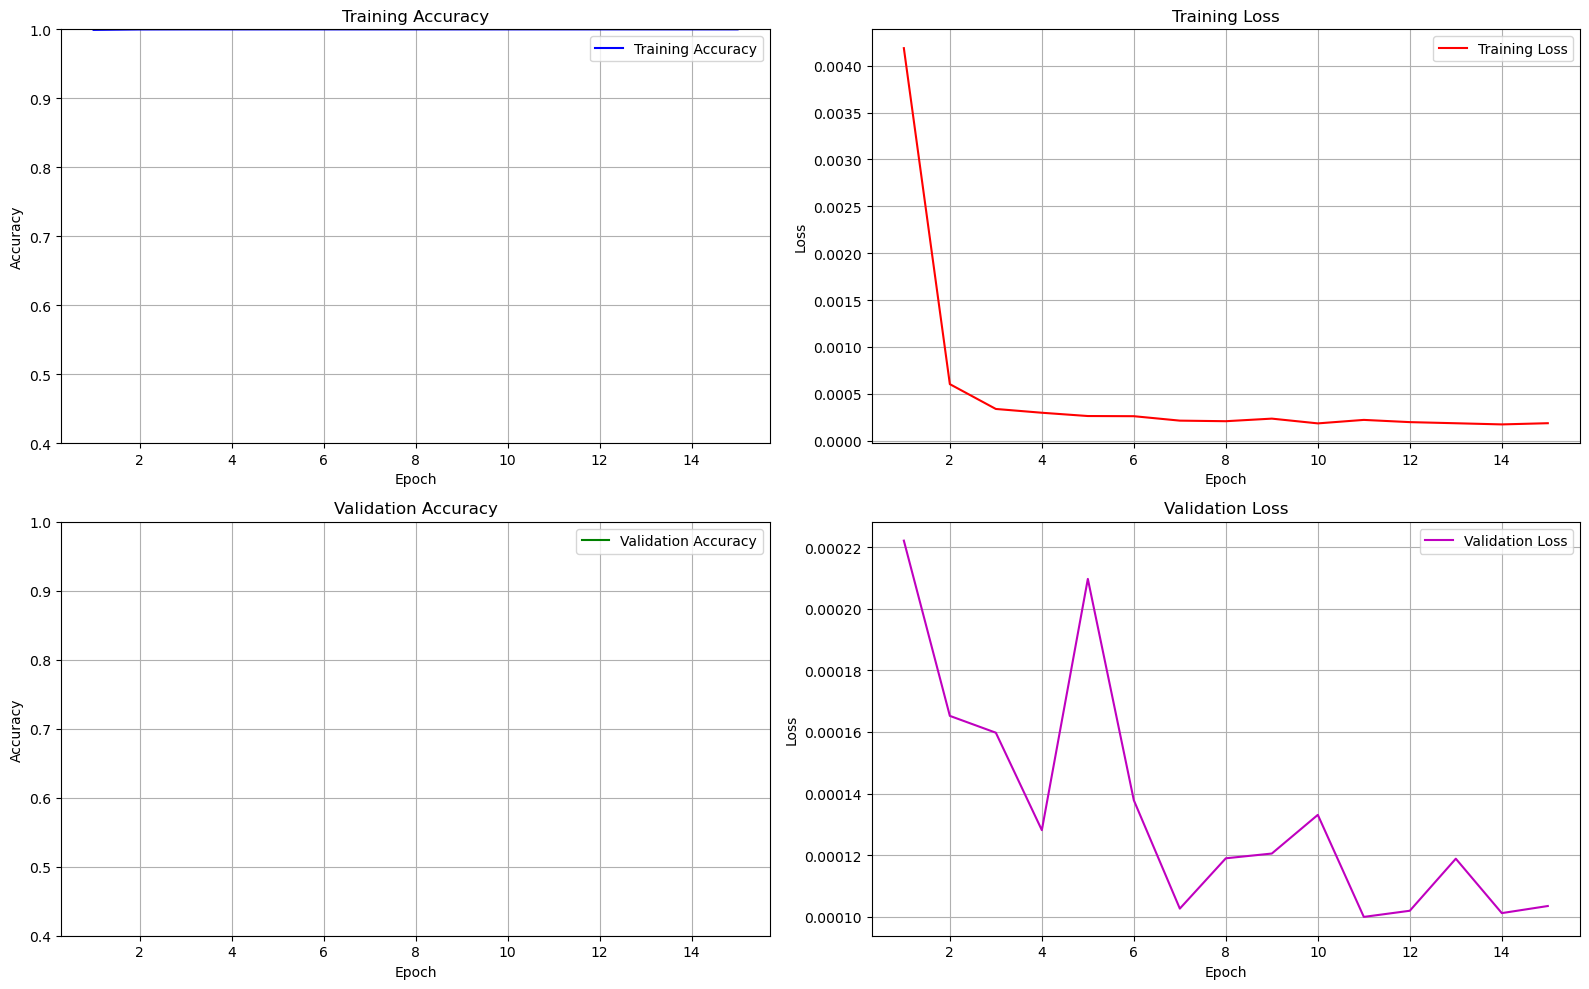

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc log từ file CSV
log_df = pd.read_csv(log_name)  # Đổi tên file nếu cần

epochs = range(1, len(log_df) + 1)

plt.figure(figsize=(16, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, log_df['accuracy'], 'b-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.ylim(0.40, 1.0)

# Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, log_df['loss'], 'r-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, log_df['val_accuracy'], 'g-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.ylim(0.40, 1.0)

# Validation Loss
plt.subplot(2, 2, 4)
plt.plot(epochs, log_df['val_loss'], 'm-', label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()